# **Motivation and References**

- NR simulations give the evolution of the binary system and the space-time metric at all spacial and temporal points in the domain of the simultaion.

- The waveform is extracted at several extraction spheres at varying finite radii and then extrapolated to future null-infinity.
<!-- (recall Scott's guest lectures). -->

- So in principle NR simulations give us a way to generate exact waveforms for a given set of parameters (masses, spins, ...), so why use/build surrogates at all!?

- NR simulations are extremely expensive computationally! So it is infeasible to run a simluation for every possible set of parameters, for tasks like generating a template bank for parameter estimation. 
<!-- (recall Collin's guest lectures). -->

- Enter **surrogates**, which are fast(er) models that are trained on existing waveforms at certain parameter values, but can give accurate waveforms for parameter values inside the training parameter space. It can roughly be seen as an interpolation problem.

-  A lot of LIGO data analysis relies of surrogate models. EOB frequency-domain Reduced Order Models (https://arxiv.org/abs/1402.4146, Michael Puerrer) is the the standard way of using EOB models in LIGO. Also, the LVK used the NR surrogates as the main model for the first intermediate-mass BH discovery.

- The literature followed for this notebook is, 
**Fast prediction and evaluation of gravitational waveforms using surrogate models**, *Scott E. Field, Chad R. Galley, Jan S. Hesthaven, Jason Kaye, Manuel Tigli* (https://arxiv.org/abs/1308.3565).

- The notebook is a rewritten and compressed version of Scott Field's and Vijay Varma's ICERM tutorial on surrogates, which is far far more comprehensive than this. Interested people can find that here: https://icerm.brown.edu/video_archive/?play=2412. 

<!-- - The theory covered in the notebook is a brief overview of Michael's 3rd guest lecture. -->

# **Prerequisites**

- Basic proficiency in linear algebra is assumed
- Basic knowledge of GW signals
<!-- , in other words I'll assume ( or hope :) ) that you paid attention to the lectures in this course. -->

In [1]:
import numpy as np
import rompy as rp
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt
# %matplotlib inline

from pycbc.waveform import td_approximants
from pycbc.waveform import get_td_waveform
from pycbc.types import timeseries
import lal

from six import iteritems
from pprint import pprint
import time

# **Steps to Building the 1D-Surrogate**

## STEP-1: Generating Training and Validation Waveforms

- For surrogate modelling to work, the following need to be ensured for the training (and validation) waveforms:
    1. peak alignment
    2. phase alignment (rescaling with the initial phase of the 2,2 mode)
    3. same duration of all signals

    This ensures that the waveforms in the training space change as little as possible with changing parameters.

- The 1D parameter for this notebook will be the mass ratio $q$.

- The goal is to model the 2,2 mode $h^{22}(t;q)$:

    \begin{align*}
    h(t, \theta, \phi; q) & = h_+(t, \theta, \phi; q) - \mathrm{i} h_x(t, \theta, \phi; q) \\
    & = \sum_{\ell=2}^{\infty} \sum_{m=-\ell}^{\ell} h^{\ell m}(t;q) {}_{-2}Y_{\ell m} \left(\theta, \phi \right) \, ,
    \end{align*}


- Additionally the following amplitude-phase decomposition is used,
    $$h(T_i;q) = A(T_i;q) \exp\left(\mathrm{j}\ \phi(T_i;q) \right)$$

    since the amplitude, $A$, and phase, $\phi$ are expected to be "easier to model" functions of $q$.

### Waveform Generation Wrapper

In [2]:
def wf_wrapper(approximant, mass1, mass2,
                delta_t, f_lower,
                chi1, chi2, distance):
    hp, hc = get_td_waveform(approximant=approximant, mass1=mass1, mass2=mass2, delta_t=delta_t,
                            f_lower=f_lower, chi1=chi1, chi2=chi2,distance=distance)
    
    h = (hp - 1.0j*hc)*(distance*1.0e6*lal.PC_SI)/((mass1+mass2)*lal.MTSUN_SI)/(lal.C_SI) # rescaling amplitude to mass units
    h = h.time_slice(-5,0) # truncating at waveform from -15 to 0
    ph = np.unwrap(np.angle(h)) # phase time series
    h *= np.exp(-1.0j*ph[0]) # phase aligning at t_start

    return h

### Training Data

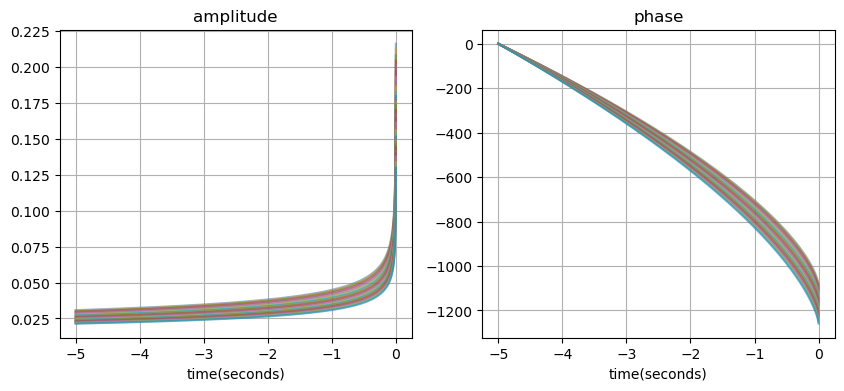

In [3]:
# MODEL PARAMETERS
approximant = "EOBNRv2"
M = 20
eps=1e-6
delta_t = 1.0/4096
f_lower = 20
chi1 = [0,0,0]
chi2 = [0,0,0]
distance = 100

q_ts = np.arange(2.0,5.0+eps,.1) # mass ratio training set
ts = [] # empty training set list

fig = plt.figure(figsize=[10,4])
axs = fig.subplots(nrows=1, ncols=2)

for q in q_ts:
    # CONVENTION: m1=BH m2=NS 
    mass1 = q*M/(1+q)
    mass2 = M/(1+q)
    
    h = wf_wrapper(approximant=approximant, mass1=mass1, mass2=mass2,
                delta_t=delta_t, f_lower=f_lower,
                chi1=chi1, chi2=chi2, distance=distance)
    ts.append([q,h])
    
    axs[0].plot(h.sample_times, abs(h.data), alpha=.5)
    axs[0].set_xlabel("time(seconds)")
    axs[0].set_title("amplitude")
    axs[0].grid()

    axs[1].plot(h.sample_times, np.unwrap(np.angle(h.data)), alpha=.5)
    axs[1].set_xlabel("time(seconds)")
    axs[1].set_title("phase")
    axs[1].grid()

times = np.array(ts[0][1].sample_times)
for t in ts:
    l = len(t[1].data)
    l0 = (5/delta_t)
    t[1] = np.array(t[1].data)
    if l>l0:
        t[1] = t[1][:-int(l-l0)]

### Validation Data

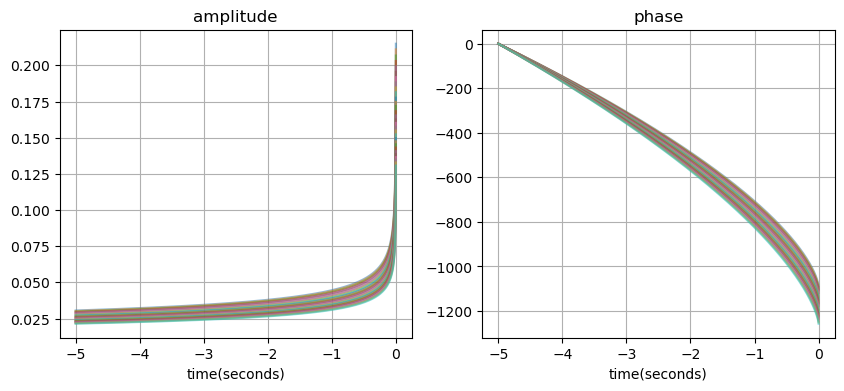

In [5]:
# MODEL PARAMETERS
approximant = "EOBNRv2"
M = 20
eps=1e-6
delta_t = 1.0/4096
f_lower = 20
lambda1 = 0
lambda2 = 0
chi1 = [0,0,0]
chi2 = [0,0,0]
distance = 100

q_vs = np.arange(2.05,4.95+eps,.1) # mass ratio validation set
vs = [] # empty validation set list

fig = plt.figure(figsize=[10,4])
axs = fig.subplots(nrows=1, ncols=2)

for q in q_vs:
    # CONVENTION: m1=BH m2=NS 
    mass1 = q*M/(1+q)
    mass2 = M/(1+q)
    
    h = wf_wrapper(approximant=approximant, mass1=mass1, mass2=mass2,
                delta_t=delta_t, f_lower=f_lower,
                chi1=chi1, chi2=chi2, distance=distance)
    vs.append([q,h])
    
    axs[0].plot(h.sample_times, abs(h.data), alpha=.5)
    axs[0].set_xlabel("time(seconds)")
    axs[0].set_title("amplitude")
    
    axs[1].plot(h.sample_times, np.unwrap(np.angle(h.data)), alpha=.5)
    axs[1].set_xlabel("time(seconds)")
    axs[1].set_title("phase")

axs[0].grid()
axs[1].grid()

for t in vs:
    l = len(t[1].data)
    l0 = (5/delta_t)
    t[1] = np.array(t[1].data)
    if l>l0:
        t[1] = t[1][:-int(l-l0)]

## STEP-2: Building a Reduced Basis of Waveforms

The goal of this is to compress the model by finding a basis for the current vector space of waveforms. This can be done via:

1. **Singular Value Decomposition (SVD)**:
    SVD compresses a matrix, via identifying the "important" columns of a matrix, where this importance is quantified by the "singular value" corresponding to each column. A column is "important" if the other columns of the matrix can be written as a linear combination of the important ones.

2. **A greedy version of the Gram-Schmidt Orthonormalization**:     
    This algorithm iteratively sweeps through the training set, picks the waveform which is worst approximated by the current basis, and then adds to the basis set the part of that waveform that is orthogonal to the current space. 

SVD is used in the notebook.

In [6]:
training_data = {"A": [], "ph": []}
for t in ts:
    training_data["ph"].append(np.unwrap(np.angle(t[1])))
    training_data["A"].append(abs(t[1]))

training_data["A"] = np.array(training_data["A"])
training_data["ph"] = np.array(training_data["ph"])

In [7]:
u, s, vh = {}, {}, {}
for key in training_data.keys():
    u[key], s[key], vh[key] = np.linalg.svd(training_data[key].transpose(), full_matrices=False)

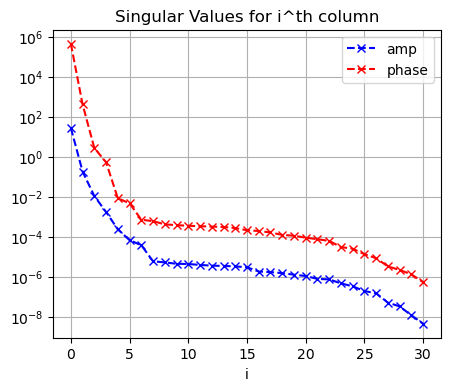

In [9]:
fig = plt.figure(figsize=[5,4])
plt.title("Singular Values for i^th column")
plt.semilogy(s["A"], marker="x", ls="--", label="amp", color="blue")
plt.semilogy(s["ph"], marker="x", ls="--", label="phase", color="red")
plt.xlabel("i")
plt.legend()
plt.grid()
plt.show()

In [10]:
basis_size = 5
basis_set = {}
for key in training_data.keys():
    basis_set[key]  = u[key][:,0:basis_size]

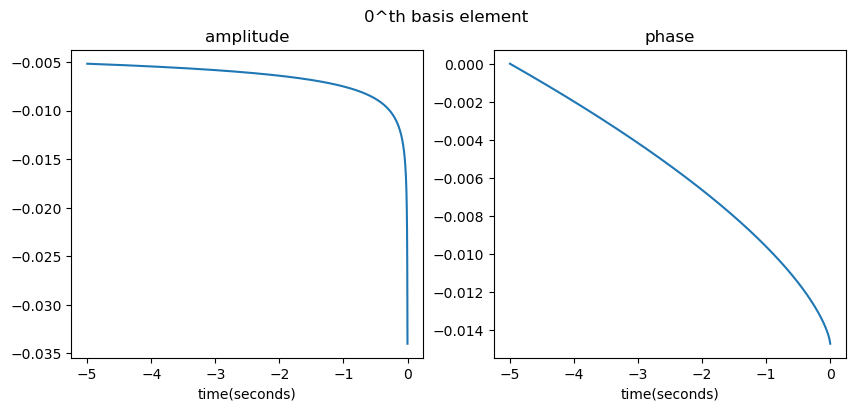

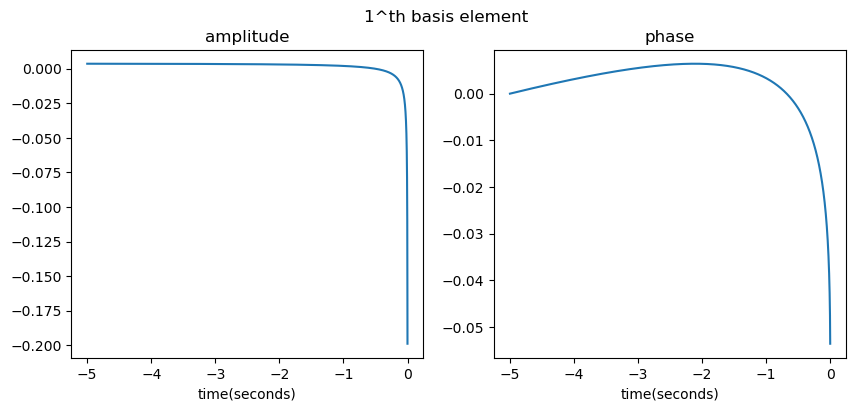

In [26]:
for i in range(2):
    fig = plt.figure(figsize=[10,4])
    axs = fig.subplots(nrows=1, ncols=2)
    fig.suptitle(f"{i}^th basis element")
    b = basis_set["A"]
    axs[0].plot(times, b[:,i])
    axs[0].set_xlabel("time(seconds)")
    axs[0].set_title("amplitude")
        
    b = basis_set["ph"]
    axs[1].plot(times, b[:,i])
    axs[1].set_xlabel("time(seconds)")
    axs[1].set_title("phase")

    plt.show()
plt.close("all")

The first $n$ basis elements can be used to compute an approximation for all waveforms in that space, which means that this process can be used as a waveform compression tool:

$$h(t;q) \approx \sum_{i=1}^n  c_i (q) u_i(t)$$

- $u_i(t)$ is the $i^{th}$ basis vector
- $c_i (q)$ is the $i^{th}$ coefficient of the representation of $h(t;q)$ in the approximation space span $\{u_i\}_{i=1}^n$. This is found by taking the inner product of $h(t;q)$ with $u_i$.

## STEP-3: Empirical Interpolation:

- The main idea is to trade the $n$ peices of information, the projection coefficients $c_i$, for direct waveform evaluations.

- Given $n$ basis elements, there (usually) exist $n$ times $\{T_i\}_{i=1}^n$ for which the set of numbers which contains equivalent information:
    $$\{ c_i (q) \}_{i=1}^n \Longleftrightarrow \{ h(T_i;q) \}_{i=1}^n$$

    $$ h (t;q) \approx \sum_{i=1}^n  c_i (q) u_i(t) \approx \sum_{i}^n h(T_i;q) B_i(t)$$

    where $B_i(t)$ are just linear combinations of $u_i(t)$ (ie the approximation space, the span of the basis, is unchanged).

- In doing this, you get special time nodes at which the waveform value is known across the parameter space values in the training set.

In [28]:
eim = {}
eim_indices = {}
B = {}

for key in basis_set.keys():
    eim[key] = rp.EmpiricalInterpolant(basis_set[key].transpose(), verbose=True)
    eim_indices[key] = eim[key].indices
    B[key] = eim[key].B

('\nStep', '\t', 'Nodes')
(1, '\t', 20479)
(2, '\t', 20289)
(3, '\t', 20475)
(4, '\t', 20458)
(5, '\t', 20478)
('\nStep', '\t', 'Nodes')
(1, '\t', 20479)
(2, '\t', 17705)
(3, '\t', 20412)
(4, '\t', 20032)
(5, '\t', 20474)


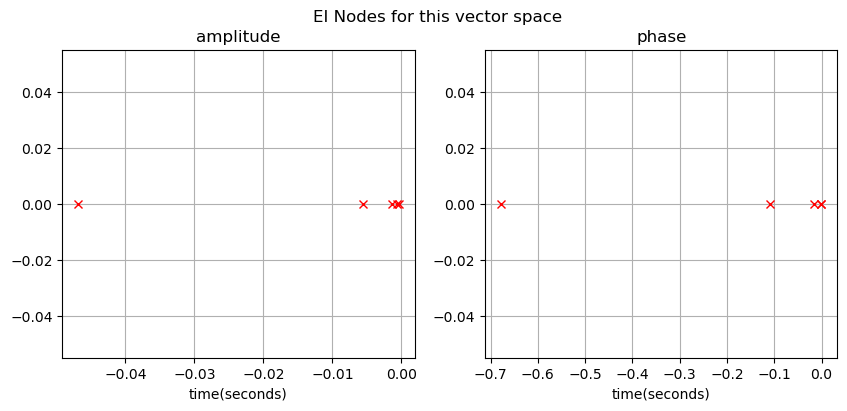

In [36]:
fig = plt.figure(figsize=[10,4])
axs = fig.subplots(nrows=1, ncols=2)
fig.suptitle(f"EI Nodes for this vector space")

e = eim_indices["A"]
axs[0].plot(times[e], np.zeros(shape=len(e)), marker="x", ls="None", color="red")
axs[0].set_xlabel("time(seconds)")
axs[0].set_title("amplitude")
axs[0].grid()
#axs[0].set_xlim(-5,0)

e = eim_indices["ph"]
axs[1].plot(times[e], np.zeros(shape=len(e)), marker="x", ls="None", color="red")
axs[1].set_xlabel("time(seconds)")
axs[1].set_title("phase")
axs[1].grid()
#axs[1].set_xlim(-5,0)

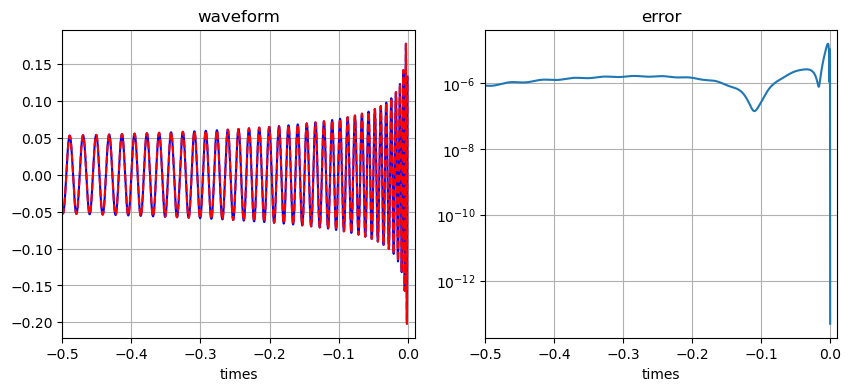

In [54]:
# Select a waveform to approximate
idx = 0 
h_i = {}
h_i["A"] = training_data["A"][idx,:]
h_i["ph"] = training_data["ph"][idx,:]

# compute the waveform at the EI nodes 
h_eim = {}
h_eim["A"] =  h_i["A"][eim_indices["A"]]
h_eim["ph"] =  h_i["ph"][eim_indices["ph"]]

h_approx = {}
h_approx["A"] = np.dot(B["A"].transpose(), h_eim["A"])
h_approx["ph"] = np.dot(B["ph"].transpose(), h_eim["ph"])

# stiching together the approximated waveform
h_full = h_i["A"]*np.exp(1.0j * h_i["ph"])
h_approx_full = h_approx["A"]*np.exp(1.0j * h_approx["ph"])

# plot the original waveform, its empirically interpolated version, and the error
fig = plt.figure(figsize=[10,4])
axs = fig.subplots(nrows=1, ncols=2)

ax = axs[0]
ax.plot(times,h_full,'blue', label="true")
ax.plot(times,h_approx_full,'r--', label="surrogate")
ax.set_xlabel("times")
ax.set_title("waveform")
ax.set_xlim(-.5,0.01)
ax.grid()

ax = axs[1]
ax.plot(times,np.abs(h_full - h_approx_full))
ax.set_yscale("log")
ax.set_xlabel("times")
ax.set_title("error")
ax.set_xlim(-.5,0.01)
ax.grid()

plt.show()
plt.close("all")

## STEP-4: Parametric Fits across Parameter Space at each EI-Node

- Once you have the EI-nodes, you can interpolate across these parameters for each time node to get $h(T_i;q')\ \forall \ q' \notin$ training set.

- And once you have these, you can approximate the waveform at those $q'$ via,

    $$ h (t;q') \approx \sum_{i}^n h(T_i;q') B_i(t) $$

- For the aforementioned interpolation, some of the options are,
    - polynomial interpolation
    - splines
    - gaussian process regression (gpr)
    - neural networks

- I'll use splines via *UnivariateSpline* in *scipy.interpolate*.

In [90]:
h_ei = {"A":[], "ph":[]}
spl_ei = {"A":[], "ph":[]}

for idx in range(len(q_ts)):
    h_i = {}
    h_i["A"] = training_data["A"][idx,:]
    h_i["ph"] = training_data["ph"][idx,:]

    h_eim = {}
    h_eim["A"] =  h_i["A"][eim_indices["A"]]
    h_eim["ph"] =  h_i["ph"][eim_indices["ph"]]
    
    #storing the h values at ei nodes for all mass ratios in the training set
    h_ei["A"].append(h_eim["A"])
    h_ei["ph"].append(h_eim["ph"])

h_ei["A"] = np.array(h_ei["A"])
h_ei["ph"] = np.array(h_ei["ph"])

for key in eim_indices.keys():
    for i in range(len(eim_indices[key])):
        spl_ei[key].append(UnivariateSpline(x=q_ts, y=h_ei[key][:,i]))

In [108]:
def full_surrogate(q):
    h_approx = {}
    h_eim = {"A": [], "ph": []}
    for key in eim_indices.keys():
        for i in range(len(eim_indices[key])):
            # interpolate the waveform at the EI nodes             
            h_eim[key].append(spl_ei[key][i](q))

        h_eim[key] = np.array(h_eim[key])
        h_approx[key] = np.dot(B[key].transpose(), h_eim[key])

    # stiching together the approximated waveform
    h_approx_full = h_approx["A"]*np.exp(1.0j * h_approx["ph"])
    
    return h_approx_full

/home/blizzard/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


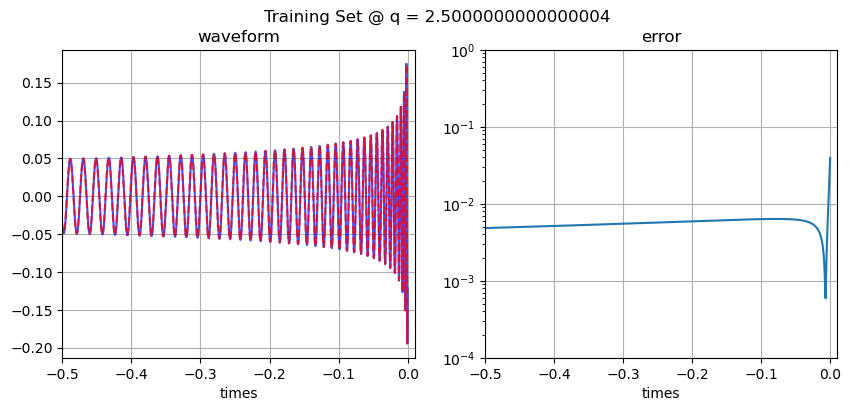

In [124]:
idx = 5
fig = plt.figure(figsize=[10,4])
axs = fig.subplots(nrows=1, ncols=2)
fig.suptitle(f"Training Set @ q = {ts[idx][0]}")

ax = axs[0]
ax.plot(times, ts[idx][1], color= 'blue', label="true", alpha=0.7)
ax.plot(times, full_surrogate(ts[idx][0]),'r--', label="surrogate", alpha=0.7)
ax.set_xlabel("times")
ax.set_title("waveform")
ax.set_xlim(-.5,0.01)
ax.grid()

ax = axs[1]
ax.plot(times, np.abs(full_surrogate(ts[idx][0]) - ts[idx][1]))
ax.set_yscale("log")
ax.set_xlabel("times")
ax.set_title("error")
ax.set_xlim(-.5,0.01)
ax.set_ylim(1e-4,1e0)
ax.grid()

plt.show()
plt.close("all")

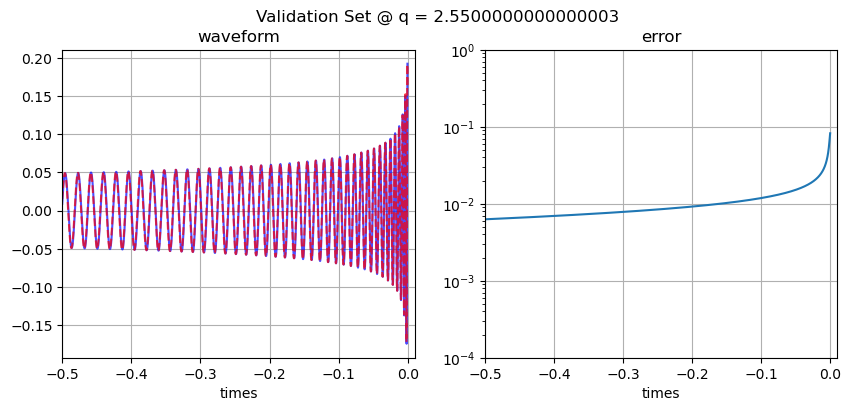

In [125]:
idx = 5
fig = plt.figure(figsize=[10,4])
axs = fig.subplots(nrows=1, ncols=2)
fig.suptitle(f"Validation Set @ q = {vs[idx][0]}")

ax = axs[0]
ax.plot(times, vs[idx][1], color= 'blue', label="true", alpha=0.7)
ax.plot(times,full_surrogate(vs[idx][0]),'r--', label="surrogate", alpha=0.7)
ax.set_xlabel("times")
ax.set_title("waveform")
ax.set_xlim(-.5,0.01)
ax.grid()

ax = axs[1]
ax.plot(times,np.abs(full_surrogate(vs[idx][0]) - vs[idx][1]))
ax.set_yscale("log")
ax.set_xlabel("times")
ax.set_title("error")
ax.set_xlim(-.5,0.01)
ax.set_ylim(1e-4,1e0)
ax.grid()

plt.show()
plt.close("all")

# Results

- So the surrogate gives a sufficiently accurate approximation for waveforms in the training and validation sets. 
- Let's also check whether the speedup that surrogates promised actually exists.

### Generating Training Set using the EOB Model

In [128]:
%%time
ts = []
for q in q_ts:
    # CONVENTION: m1=BH m2=NS 
    mass1 = q*M/(1+q)
    mass2 = M/(1+q)
    
    h = wf_wrapper(approximant=approximant, mass1=mass1, mass2=mass2,
                delta_t=delta_t, f_lower=f_lower,
                chi1=chi1, chi2=chi2, distance=distance)
    ts.append([q,h])

CPU times: user 10.4 s, sys: 49.4 ms, total: 10.5 s
Wall time: 10.7 s


### Generating the Training Set using Surrogates:

In [129]:
%%time
ts_surr = []
for q in q_ts:
    h = full_surrogate(q)
    ts_surr.append([q,h])

CPU times: user 175 ms, sys: 152 ms, total: 327 ms
Wall time: 210 ms


50X Speedup!

## Limitations:

- Only valid within the region of the parameter space the model was trained on. They can in principle extrapolate, but cannot be expected to give very accurate waveforms in the extrapolated region. This also includes $t \in [t_{min}, t_{max}]$.

- They are not a waveform generation algorithm, i.e. they require already existing waveforms at some parameter values. They hence do not replace the need for NR or EOB based waveform models!

## Considerations/Choices to be made while building the surrogate:

- The distribution of the training set parameters
- Choice of decomposition of waveforms
- Number of basis elements or the tolerance on basis and ei errors
- Choice of interpolating function, regression algorithm, ... etc